In [228]:
import pandas_datareader.data as web
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [229]:
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None)

In [230]:
df = pd.read_csv('/Users/kata/Desktop/GitHub/standby_duty_forecasting/sickness_table.csv', index_col=0)
df.head()

,date,n_sick,calls,n_duty,n_sby,sby_need,dafted
0,2016-04-01,73,8154.0,1700,90,4.0,0.0
1,2016-04-02,64,8526.0,1700,90,70.0,0.0
2,2016-04-03,68,8088.0,1700,90,0.0,0.0
3,2016-04-04,71,7044.0,1700,90,0.0,0.0
4,2016-04-05,63,7236.0,1700,90,0.0,0.0


# Mean Squared Error Model

Calculate the MSE for the exising practice with 90 standby drivers by default.

In [231]:
mean_squared_error(df.n_sby.iloc[920:], df.sby_need.iloc[920:])

12623.051724137931

The mean squared error for the existing method is 10830732.0

# Linear Regression for comparison

In [232]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [233]:
model = LinearRegression()

In [234]:
# train test split
X = df.index.values.reshape(-1,1)
y = df.sby_need.values.reshape(-1,1)



In [235]:
#def train_test_split(data, n_test):
	#return data[:-n_test, :], data[-n_test:, :]

In [236]:
def train_test_split(data, n_test):
	return data[:n_test], data[n_test:]

In [237]:
x_train, x_test = train_test_split(X, 921)
y_train, y_test = train_test_split(y, 921)


In [189]:
x_train, x_test = train_test_split(X, 231)
y_train, y_test = train_test_split(y, 231)

In [220]:
x_train

array([[  0],
       [  1],
       [  2],
       [  3],
       [  4],
       [  5],
       [  6],
       [  7],
       [  8],
       [  9],
       [ 10],
       [ 11],
       [ 12],
       [ 13],
       [ 14],
       [ 15],
       [ 16],
       [ 17],
       [ 18],
       [ 19],
       [ 20],
       [ 21],
       [ 22],
       [ 23],
       [ 24],
       [ 25],
       [ 26],
       [ 27],
       [ 28],
       [ 29],
       [ 30],
       [ 31],
       [ 32],
       [ 33],
       [ 34],
       [ 35],
       [ 36],
       [ 37],
       [ 38],
       [ 39],
       [ 40],
       [ 41],
       [ 42],
       [ 43],
       [ 44],
       [ 45],
       [ 46],
       [ 47],
       [ 48],
       [ 49],
       [ 50],
       [ 51],
       [ 52],
       [ 53],
       [ 54],
       [ 55],
       [ 56],
       [ 57],
       [ 58],
       [ 59],
       [ 60],
       [ 61],
       [ 62],
       [ 63],
       [ 64],
       [ 65],
       [ 66],
       [ 67],
       [ 68],
       [ 69],
       [ 70],
      

In [238]:
model.fit(x_train, y_train)

LinearRegression()

In [239]:
import numpy as np
pred_test = model.predict(x_test)
pred_train = model.predict(x_train)
pred = np.append(pred_train, pred_test)

df['y_predicted'] = pred

In [240]:
df.head()

,date,n_sick,calls,n_duty,n_sby,sby_need,dafted,y_predicted
0,2016-04-01,73,8154.0,1700,90,4.0,0.0,22.949082
1,2016-04-02,64,8526.0,1700,90,70.0,0.0,22.964398
2,2016-04-03,68,8088.0,1700,90,0.0,0.0,22.979714
3,2016-04-04,71,7044.0,1700,90,0.0,0.0,22.995030
4,2016-04-05,63,7236.0,1700,90,0.0,0.0,23.010347


In [241]:
df.head()

,date,n_sick,calls,n_duty,n_sby,sby_need,dafted,y_predicted
0,2016-04-01,73,8154.0,1700,90,4.0,0.0,22.949082
1,2016-04-02,64,8526.0,1700,90,70.0,0.0,22.964398
2,2016-04-03,68,8088.0,1700,90,0.0,0.0,22.979714
3,2016-04-04,71,7044.0,1700,90,0.0,0.0,22.995030
4,2016-04-05,63,7236.0,1700,90,0.0,0.0,23.010347


In [242]:
# slope of the line
model.coef_

array([[0.01531628]])

In [243]:
# intercept of the line
model.intercept_

array([22.94908157])

In [244]:
# calculate mse
from sklearn.metrics import mean_squared_error, r2_score

In [250]:
# The coefficients
print("Coefficients:")
print("Slope: " + str(model.coef_))
print("y-intercept: " + str(model.intercept_))
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(df['sby_need'].iloc[920:], df['y_predicted'].iloc[920:]))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(df['sby_need'].iloc[920:], df['y_predicted'].iloc[920:]))


Coefficients:
Slope: [[0.01531628]]
y-intercept: [22.94908157]
Mean squared error: 11484.31
Coefficient of determination: -0.01


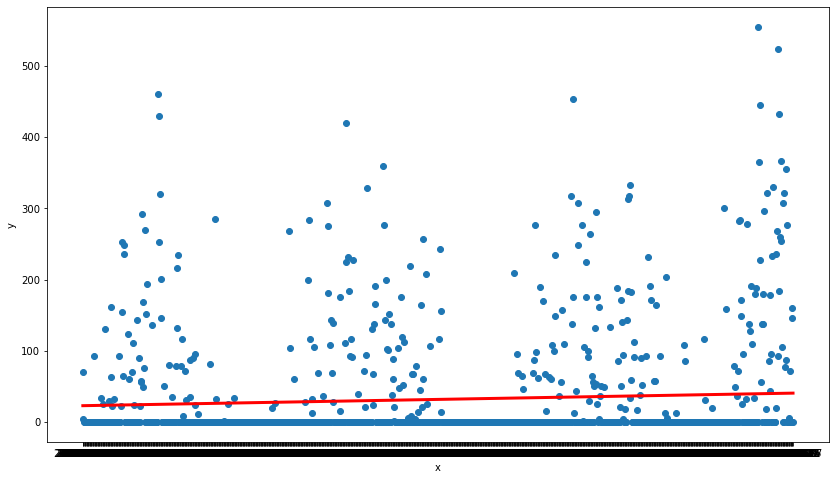

In [246]:
# plot the results
plt.figure(figsize=(14, 8))
ax = plt.axes()
ax.scatter(df.date, y)
ax.plot(df.date, pred, color='red', linewidth=3)

ax.set_xlabel('x')
ax.set_ylabel('y')

ax.axis('tight')


plt.show()

In [ ]:
import sys

In [ ]:
print(sys.executable)

In [248]:
mean_squared_error(df.sby_need.iloc[:920], df.y_predicted.iloc[:920])

4953.488078236161